In [1]:
import lightgbm as lgb
from data_pipeline import data_transform_pipeline, cap_sales
import pandas as pd
from sklearn.metrics import mean_squared_error
import re

data = pd.read_csv('data/train.csv')

train_data = data[data['date'] < '2017-08-01']
train_data = cap_sales(train_data, 6500)
test_data = data[data['date'] >= '2017-08-01']
test_data = cap_sales(test_data, 6500)

X_train = train_data
y_train = X_train.pop('sales')

X_test = test_data
y_test = X_test.pop('sales')

X_train = data_transform_pipeline.fit_transform(X_train)
X_test = data_transform_pipeline.transform(X_test)

c:\Users\tzbk\CODIGOS\python\machine_learning\time_series_ml_analysis\data_pipeline.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sales = df.sales.map(lambda x: x if x < cap else cap)


In [2]:
X_train.columns

Index(['onpromotion', 'cluster', 'is_holiday', 'oil_price', 'month', 'year',
       'day_of_week', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')

In [3]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
model = lgb.LGBMRegressor(force_row_wise=True, n_estimators=500, learning_rate=0.1, num_leaves=100, subsample=0.8, colsample_bytree=0.8, max_depth=100, random_state=42)

In [5]:
model.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 2974158, number of used features: 40
[LightGBM] [Info] Start training from score 337.277697


LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, max_depth=100,
              n_estimators=500, num_leaves=100, random_state=42, subsample=0.8)

In [9]:
# Obtain gain feature importance
gain_importance = model.feature_importances_

# Display feature importance with feature names
feature_names = X_train.columns
gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

                           Feature   Gain
3                        oil_price  13268
0                      onpromotion   9998
1                          cluster   7524
4                            month   6034
6                      day_of_week   4405
5                             year   2279
19                 family_GROCERYI   1165
10                family_BEVERAGES    985
2                       is_holiday    960
37                  family_PRODUCE    560
14                 family_CLEANING    311
15                    family_DAIRY    252
25                 family_HOMECARE    131
12              family_BREADBAKERY    115
16                     family_DELI    112
18              family_FROZENFOODS    108
35                  family_POULTRY    103
31                    family_MEATS     97
17                     family_EGGS     87
32             family_PERSONALCARE     86
29           family_LIQUORWINEBEER     72
36            family_PREPAREDFOODS     66
38  family_SCHOOLANDOFFICESUPPLIES

In [6]:
predictions = model.predict(X_test)
# predictions = np.e **predictions + 1
# y_test = np.e ** y_test  + 1
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")

MSE: 419222.47082704364
ROOT of MSE: 647.4739151711393


In [3]:
model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 3000888, number of used features: 40
[LightGBM] [Info] Start training from score 338.214939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, max_depth=10,
              n_estimators=500, num_leaves=100, random_state=42, subsample=0.8)

In [4]:
X_competition = pd.read_csv('data/test.csv')
competition_indexes = X_competition['id']
X_competition = data_transform_pipeline.transform(X_competition)
X_competition = X_competition.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
competition_prediction = model.predict(X_competition)
competition_prediction[competition_prediction < 0] = 0


In [48]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/submission.csv', index=False)

LN approach

In [35]:
import numpy as np

y_train_log = np.log1p(y_train)

model.fit(X_train, y_train_log)
predictions_log = model.predict(X_test)
predictions = np.expm1(predictions_log)

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")



[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 2974158, number of used features: 40
[LightGBM] [Info] Start training from score 2.917812
MSE: 779427.0126501742
ROOT of MSE: 882.8516368281673


In [42]:
predictions_train = model.predict(X_train)
print(f"MSE: {mean_squared_error(y_train, predictions_train)}")
print(f"ROOT of MSE: {mean_squared_error(y_train, predictions_train)**0.5}")

MSE: 296602.7318815338
ROOT of MSE: 544.6124602701758


Linear model

In [5]:
from sklearn.linear_model import LinearRegression

# Create an instance of LinearRegression
linear_model = LinearRegression()

In [ ]:
# Fit the model to your training data
linear_model.fit(X_train, y_train)

# Make predictions
predictions = linear_model.predict(X_test)

In [60]:
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")

MSE: 382735.53260258527
ROOT of MSE: 618.6562313616386


In [6]:
linear_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

competition_prediction_linear = linear_model.predict(X_competition)

competition_prediction_linear[competition_prediction_linear < 0] = 0

In [ ]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/linear_submission.csv', index=False)

In [ ]:
X_competition

In [7]:
competition_prediction

array([8.16501585e-01, 0.00000000e+00, 1.25849533e+01, ...,
       1.19327193e+03, 7.47549445e+01, 2.52801040e+01])

In [8]:
competition_prediction_linear

array([   0.        ,    0.        ,    0.        , ..., 1231.93945312,
         18.70703125,   26.921875  ])

In [10]:
competition_prediction = (competition_prediction + competition_prediction_linear)/2

In [11]:
competition_prediction

array([4.08250792e-01, 0.00000000e+00, 6.29247667e+00, ...,
       1.21260569e+03, 4.67309879e+01, 2.61009895e+01])

In [12]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/joined_submission.csv', index=False)

RNN With LSTM Approach

In [44]:
import torch
import torch.nn as nn
import numpy as np


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)

        out, _ = self.lstm3(out)
        out = self.fc(out)
        return out

# Configuración del modelo
input_size = 40
hidden_size = 1
num_layers = 1
output_size = 1
dropout = 0.2

# Crear una instancia del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

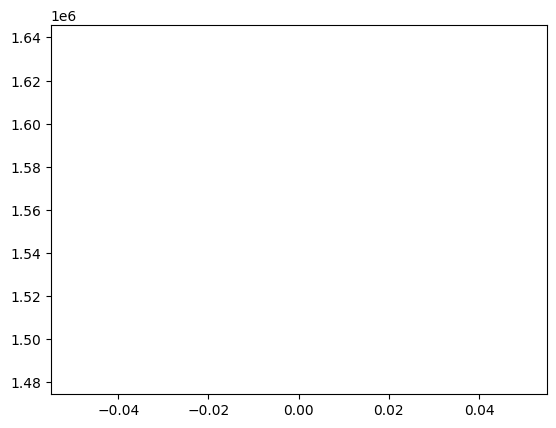

Epoch [1/25], Loss: 1560123.3750


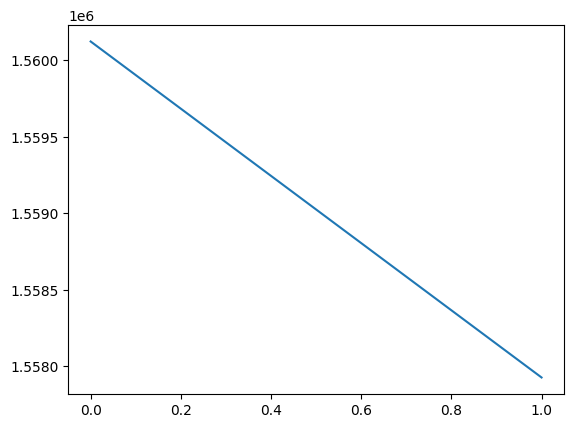

Epoch [2/25], Loss: 1557928.2500


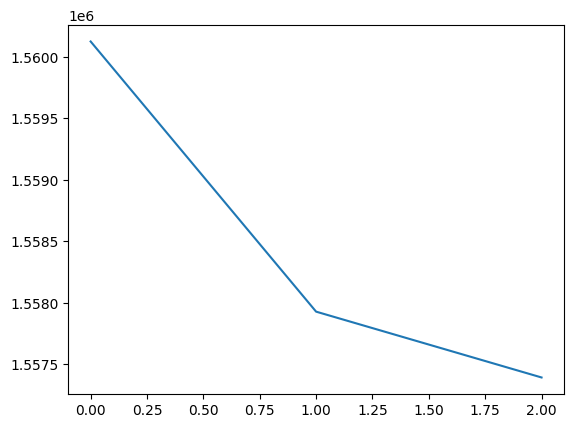

Epoch [3/25], Loss: 1557393.3750


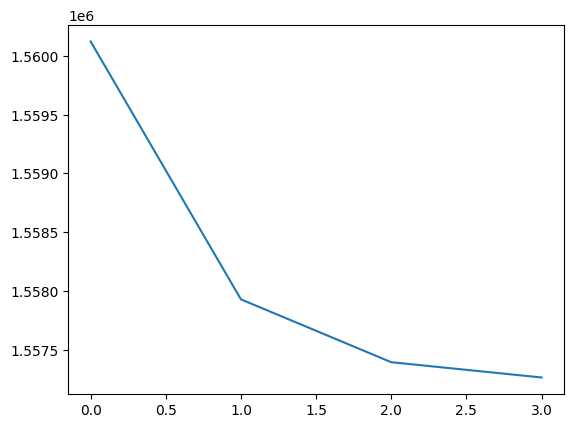

Epoch [4/25], Loss: 1557263.3750


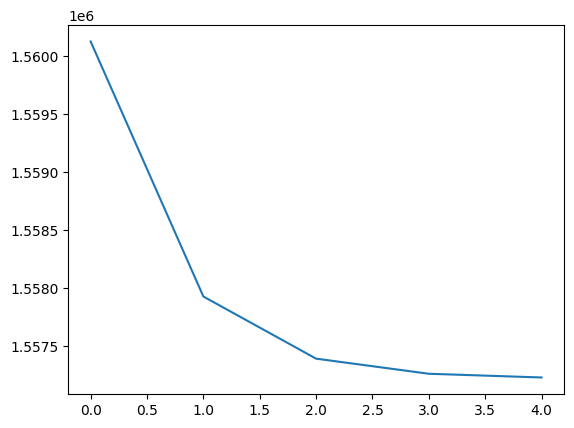

Epoch [5/25], Loss: 1557231.3750


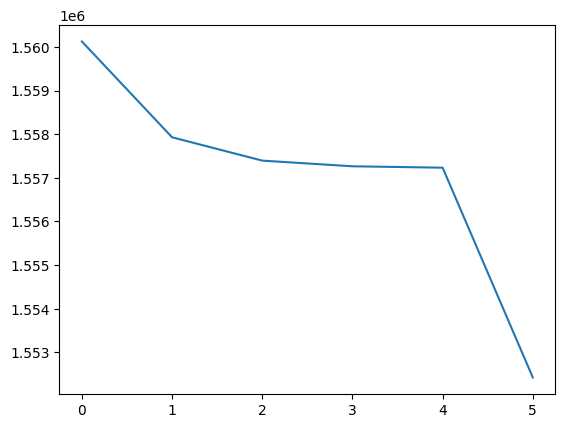

Epoch [6/25], Loss: 1552424.2500


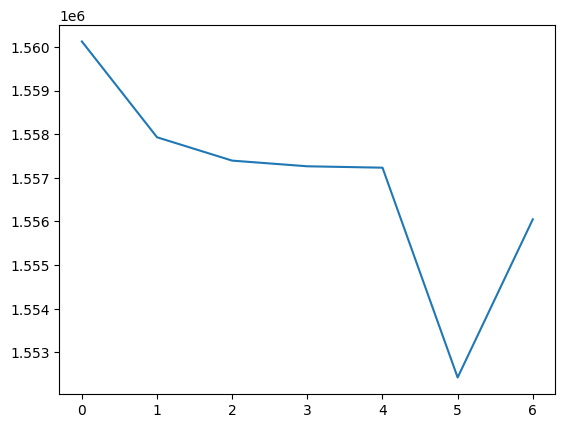

Epoch [7/25], Loss: 1556048.2500


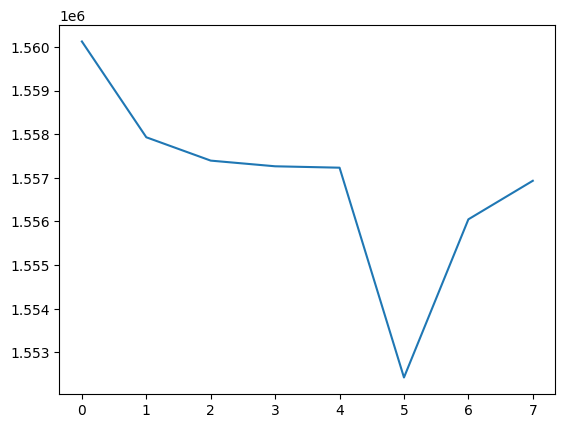

Epoch [8/25], Loss: 1556931.5000


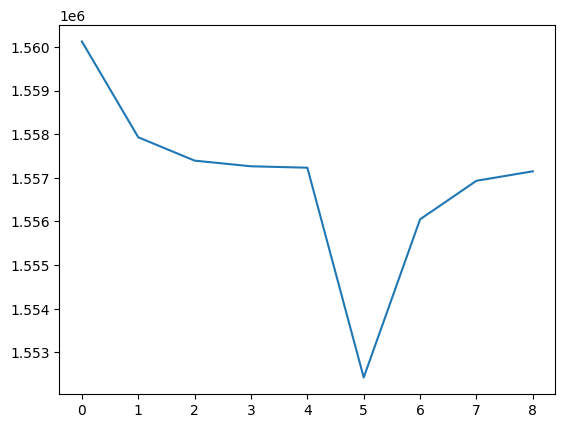

Epoch [9/25], Loss: 1557148.3750


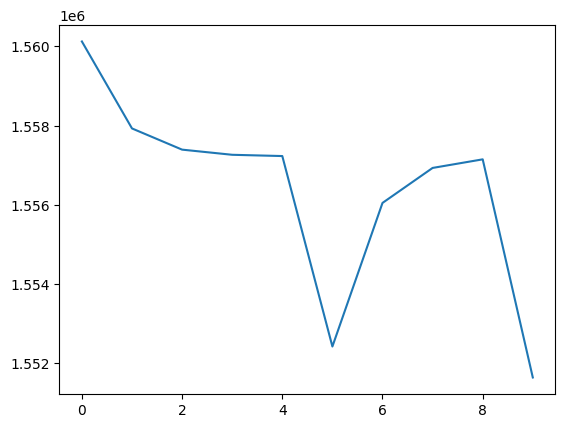

Epoch [10/25], Loss: 1551642.5000


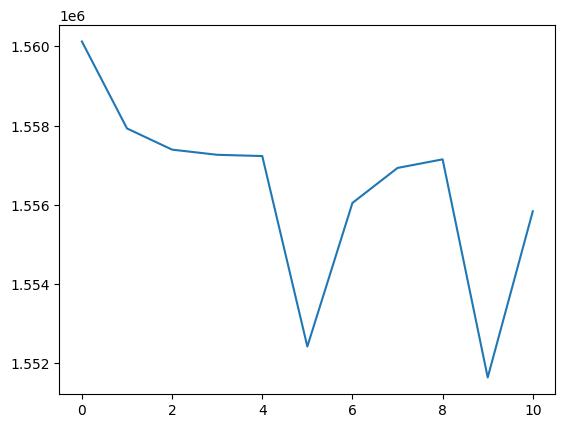

Epoch [11/25], Loss: 1555838.0000


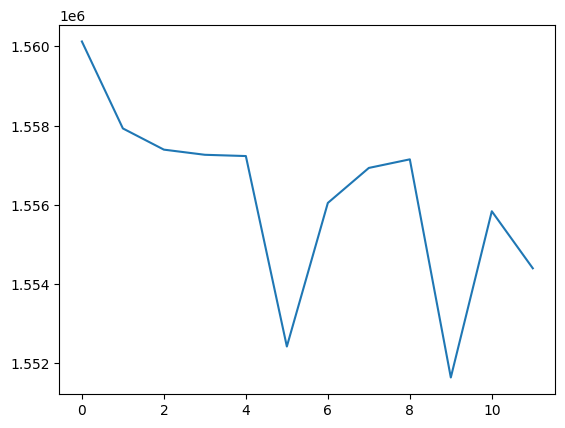

Epoch [12/25], Loss: 1554398.2500


In [46]:
import matplotlib.pyplot as plt
# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train.values.astype(np.float32)).to(device)
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).reshape(-1, 1).to(device)

batch_size = 1000
# Entrenar el modelo
num_epochs = 25
total_data_size = X_train_tensor.shape[0]

losses = []
epochs = []

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        outputs = model(X_batch)
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    epochs.append(epoch)
    losses.append(loss.item())
    plt.plot(epochs, losses)
    plt.show()
    # if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [40]:
with torch.no_grad():
    predictions = model(torch.tensor(X_train.values.astype(np.float32)).to(device))

In [41]:
print(f"MSE: {mean_squared_error(y_train, predictions.cpu())}")
print(f"ROOT of MSE: {mean_squared_error(y_train, predictions.cpu())**0.5}")

MSE: 852237.2835995967
ROOT of MSE: 923.1669857612959


In [36]:
print(X_train_tensor.shape)
print(y_train_tensor.reshape(-1, 1).shape)

torch.Size([2974158, 40])
torch.Size([2974158, 1])


In [9]:
for i, epoch in enumerate(range(0, num_epochs, batch_size)):
    print(i)
    print(epoch)

0
0
1
100
2
200
3
300
4
400


In [7]:
enumerate(range(0, num_epochs, batch_size))